# 1. Define dependencies, variables, DataIO

✅Update alpha here

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.optimize
alpha = 13.9

In [118]:
import os

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅Paste paths of data from different acquisition speeds

In [119]:
# os.chdir('/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/C_Data/') #切換該目錄
# os.listdir() #確認目錄內容

# Get the path for loading & saving data
Path_Raw_Fast = '/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/C_Data/Merged_Fast.xlsx'
Path_Raw_Slow = "/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/C_Data/Merged_Slow.xlsx"
# Save the result to the same foler
Path_Result = "/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/C_Data/Normalized from Fast and Slow.xlsx"

In [120]:
 # Load Data
Table_Raw_Fast = pd.read_excel(Path_Raw_Fast, header = 0)
Table_Raw_Slow = pd.read_excel(Path_Raw_Slow, header = 0)
Table_Raw_Fast

,Track Duration,Corrected Track No,Lifetime,Normalized track population
0,1,545.649832,0.602,0.323982
1,2,296.979730,1.204,0.176333
2,3,183.454237,1.806,0.108927
3,4,112.887755,2.408,0.067028
4,5,64.290102,3.010,0.038172
...,...,...,...,...
76,142,1.916667,85.484,0.001138
77,159,2.151079,95.718,0.001277
78,161,2.182482,96.922,0.001296
79,176,2.450820,105.952,0.001455


# 2. Normalize F(t) with alpha

In [121]:
# Data wrangling
Table_Raw_Fast["Normalized track population"] = Table_Raw_Fast["Normalized track population"] * alpha
Table_Raw_Fast

,Track Duration,Corrected Track No,Lifetime,Normalized track population
0,1,545.649832,0.602,4.503344
1,2,296.979730,1.204,2.451026
2,3,183.454237,1.806,1.514080
3,4,112.887755,2.408,0.931682
4,5,64.290102,3.010,0.530598
...,...,...,...,...
76,142,1.916667,85.484,0.015819
77,159,2.151079,95.718,0.017753
78,161,2.182482,96.922,0.018012
79,176,2.450820,105.952,0.020227


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


R² of dual exponential fitting= 0.998829518900974


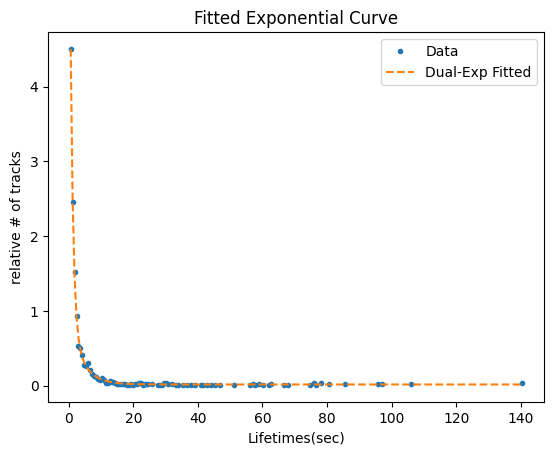

Y = 7.675056750237037 * e^(-1.2107631878044094 * x) + 0.913375956086224 * e^(-0.2542088403176548 * x) + 0.01514530480744161
Tau1d = 0.8259253420261264 s; Amplitude 1 = 7.675056750237037
Tau2d = 3.933773501938084 s; Amplitude 2 = 0.913375956086224


In [122]:
#Define the dualexponential decay funciton
def duExp(x, a1d, t1d, a2d, t2d, b2):
    return a1d * np.exp(-t1d *x) + a2d * np.exp(-t2d * x) + b2

# perform the dualexponential fit
xs = Table_Raw_Fast["Lifetime"]
ys = Table_Raw_Fast["Normalized track population"]
p0 = (Table_Raw_Fast["Normalized track population"].max(), .1, Table_Raw_Fast["Normalized track population"].max(), .1,0) # start with values near those we expect
poptd, cvd = scipy.optimize.curve_fit(duExp, xs, ys, p0)
a1d, t1d, a2d, t2d, b2 = poptd
tau1dSec = (1 / t1d)
tau2dSec = (1 / t2d)

# determine quality of the dualexponential fit
squaredDiffs = np.square(ys - duExp(xs, a1d, t1d, a2d, t2d, b2))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² of dual exponential fitting= {rSquared}")

# plot the dualexponential fit results
plt.plot(xs, ys, '.', label="Data")
plt.plot(xs, duExp(xs, a1d, t1d, a2d, t2d, b2), '--', label="Dual-Exp Fitted")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("relative # of tracks")
plt.title("Fitted Exponential Curve")
plt.legend()
plt.show()

# inspect the dualexponential parameters
print(f"Y = {a1d} * e^(-{t1d} * x) + {a2d} * e^(-{t2d} * x) + {b2}")
print(f"Tau1d = {tau1dSec * 1} s; Amplitude 1 = {a1d}")
print(f"Tau2d = {tau2dSec * 1} s; Amplitude 2 = {a2d}")

# 3 Create normalized dataframe

## 3.1 Create the datapoints

In [123]:
#Normalized_df = pd.DataFrame.copy(Table_Raw_Fast)
#Normalized_df = Normalized_df.append(Table_Raw_Slow)
Normalized_df = pd.concat([Table_Raw_Fast, Table_Raw_Slow])
Normalized_df = Normalized_df.drop(columns = ["Track Duration", "Corrected Track No", "Normalized track population"])
Normalized_df.sort_values(by = ["Lifetime"], inplace = True)
Normalized_df

,Lifetime
0,0.602
1,1.204
2,1.806
0,2.214
3,2.408
...,...
105,312.174
106,343.170
107,380.808
108,394.092


## 3.2 Get Normalized F(t)

In [124]:
Normalized_df["Population from F(t)"] = duExp(Normalized_df["Lifetime"], a1d, t1d, a2d, t2d, b2)
Normalized_df

,Lifetime,Population from F(t)
0,0.602,4.501740
1,1.204,2.474123
2,1.806,1.454123
0,2.214,1.061300
3,2.408,0.926174
...,...,...
105,312.174,0.015145
106,343.170,0.015145
107,380.808,0.015145
108,394.092,0.015145


## 3.3 Get Normalize S(t)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


R² of dual exponential fitting= 0.9770499712344127


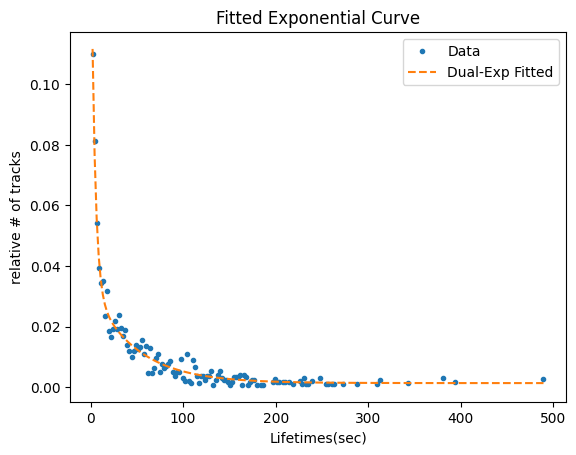

Y = 0.03193163162896403 * e^(-0.021106911856439155 * x) + 0.13842469786113062 * e^(-0.24886388605832999 * x) + 0.0013845164381714255
Tau1d = 47.377845077555804 s; Amplitude 1 = 0.03193163162896403
Tau2d = 4.018260808503227 s; Amplitude 2 = 0.13842469786113062


In [125]:
#Define the dualexponential decay funciton
def duExp(x, a1d, t1d, a2d, t2d, b2):
    return a1d * np.exp(-t1d *x) + a2d * np.exp(-t2d * x) + b2

# perform the dualexponential fit
xs = Table_Raw_Slow["Lifetime"]
ys = Table_Raw_Slow["Normalized track population"]
p0 = (Table_Raw_Slow["Normalized track population"].max(), .1, Table_Raw_Slow["Normalized track population"].max(), .1,0) # start with values near those we expect
poptd, cvd = scipy.optimize.curve_fit(duExp, xs, ys, p0)
a1d, t1d, a2d, t2d, b2 = poptd
tau1dSec = (1 / t1d)
tau2dSec = (1 / t2d)

# determine quality of the dualexponential fit
squaredDiffs = np.square(ys - duExp(xs, a1d, t1d, a2d, t2d, b2))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² of dual exponential fitting= {rSquared}")

# plot the dualexponential fit results
plt.plot(xs, ys, '.', label="Data")
plt.plot(xs, duExp(xs, a1d, t1d, a2d, t2d, b2), '--', label="Dual-Exp Fitted")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("relative # of tracks")
plt.title("Fitted Exponential Curve")
plt.legend()
plt.show()

# inspect the dualexponential parameters
print(f"Y = {a1d} * e^(-{t1d} * x) + {a2d} * e^(-{t2d} * x) + {b2}")
print(f"Tau1d = {tau1dSec * 1} s; Amplitude 1 = {a1d}")
print(f"Tau2d = {tau2dSec * 1} s; Amplitude 2 = {a2d}")

In [126]:
Normalized_df["Population from S(t)"] = duExp(Normalized_df["Lifetime"], a1d, t1d, a2d, t2d, b2)
Normalized_df['Histogram merged population'] = Normalized_df["Population from F(t)"] + Normalized_df["Population from S(t)"]
Normalized_df["Normalized track population"] = Normalized_df["Histogram merged population"] / Normalized_df["Histogram merged population"].sum()
Normalized_df.to_excel(Path_Result)
Normalized_df

,Lifetime,Population from F(t),Population from S(t),Histogram merged population,Normalized track population
0,0.602,4.501740,0.152078,4.653818,0.224109
1,1.204,2.474123,0.135100,2.609224,0.125650
2,1.806,1.454123,0.120434,1.574557,0.075824
0,2.214,1.061300,0.111644,1.172944,0.056484
3,2.408,0.926174,0.107759,1.033933,0.049790
...,...,...,...,...,...
105,312.174,0.015145,0.001428,0.016574,0.000798
106,343.170,0.015145,0.001407,0.016553,0.000797
107,380.808,0.015145,0.001395,0.016540,0.000797
108,394.092,0.015145,0.001392,0.016538,0.000796


Text(0.5, 1.0, 'Track # vs Lifetime')

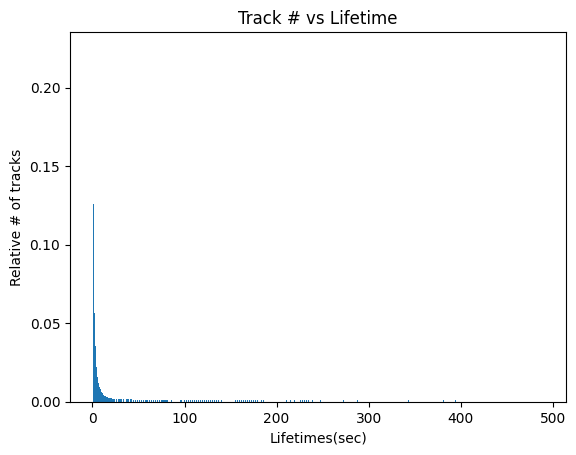

In [127]:
# Plot relative # of tracks vs lifetime
xs = Normalized_df["Lifetime"]
#ys = Normalized_df["Histogram merged population"]
ys = Normalized_df["Normalized track population"]
plt.bar(xs,ys)
plt.xlabel("Lifetimes(sec)")
plt.ylabel("Relative # of tracks")
plt.title("Track # vs Lifetime")

# 3. Triple exponential fitting

## 3.1 Fitting

R² of triple exponential fitting= 0.999999999998793


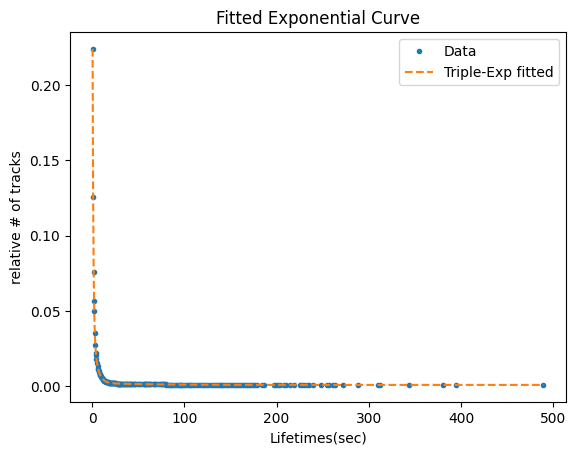

Y = 0.0015379202944051527 * e^(-0.021110069112163173 * x) + 0.05064676288638449 * e^(-0.2534855230263323 * x) + 0.3696024178662836 * e^(-1.210751069217305 * x)+ 0.000796026528816666
Tau1t = 47.37075917121566 s; Amplitude 1 = 0.0015379202944051527
Tau2t = 3.9449984680037096 s; Amplitude 2 = 0.05064676288638449
Tau3t = 0.8259336088354265 s; Amplitude 3 = 0.3696024178662836


In [128]:
def tpExp(x, a1t, t1t, a2t, t2t, a3t, t3t, b3):
    return a1t * np.exp(-t1t *x) + a2t * np.exp(-t2t * x) + a3t * np.exp(-t3t * x) + b3

# Perform the triple exponential fit
xs = Normalized_df["Lifetime"]
#ys = Normalized_df['Histogram merged population']
ys = Normalized_df['Normalized track population']
p0 = (Normalized_df['Normalized track population'].max(), 0.02, Normalized_df['Normalized track population'].max(), 0.25,Normalized_df['Normalized track population'].max(), 1.25,0) # start with values near those we expect
poptt, cvt = scipy.optimize.curve_fit(tpExp, xs, ys , p0)#optimized parameters and covariants
a1t, t1t, a2t, t2t, a3t, t3t, b3 = poptt
tau1tSec = (1 / t1t)
tau2tSec = (1 / t2t)
tau3tSec = (1 / t3t)

# Determine quality of the triple exponential fit
squaredDiffs = np.square(ys - tpExp(xs, a1t, t1t, a2t, t2t, a3t, t3t, b3))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² of triple exponential fitting= {rSquared}")

# plot the triple exponential fit results
plt.plot(xs, ys, '.', label="Data")
plt.plot(xs, tpExp(xs, a1t, t1t, a2t, t2t, a3t, t3t, b3), '--', label="Triple-Exp fitted")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("relative # of tracks")
plt.title("Fitted Exponential Curve")
plt.legend()
plt.show()

# inspect the monoexponential parameters
print(f"Y = {a1t} * e^(-{t1t} * x) + {a2t} * e^(-{t2t} * x) + {a3t} * e^(-{t3t} * x)+ {b3}")
print(f"Tau1t = {tau1tSec * 1} s; Amplitude 1 = {a1t}")
print(f"Tau2t = {tau2tSec * 1} s; Amplitude 2 = {a2t}")
print(f"Tau3t = {tau3tSec * 1} s; Amplitude 3 = {a3t}")

3.2 Plot frequency vs lifetime of the triple exponential model

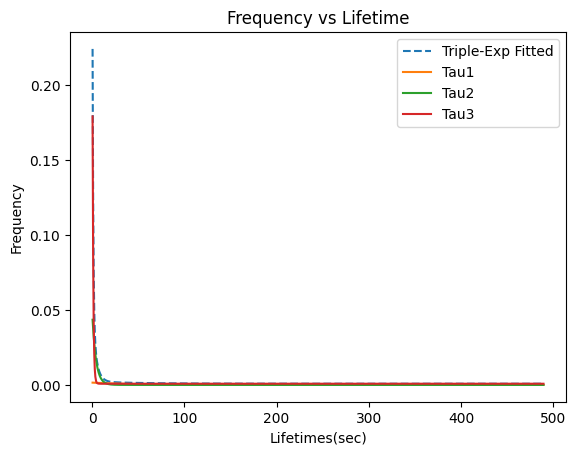

In [129]:
def monoExp(x, a1, t1, b1):
    return a1 * np.exp(-t1 * x) + b1
# Plot frequency vs lifttime
plt.plot(xs, tpExp(xs, a1t, t1t, a2t, t2t, a3t, t3t, b3), '--', label="Triple-Exp Fitted")
plt.plot(xs, monoExp(xs, a1t, t1t,0), '-', label="Tau1")
plt.plot(xs, monoExp(xs, a2t, t2t,0), '-', label="Tau2")
plt.plot(xs, monoExp(xs, a3t, t3t,b3), '-', label="Tau3")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("Frequency")
plt.title("Frequency vs Lifetime")
plt.legend()
plt.show()

# 4. Relative contributions of each component

## 4.1 Calculate the critical point of the dual function and Classify

In [130]:
# Get the parameters for each classification
Tau_df = pd.DataFrame({
 "Parameter":["Tau", "a", "t", "b"],
 "Tau1": [tau1tSec, a1t, t1t, 0],
 "Tau2": [tau2tSec, a2t, t2t, 0],
 "Tau3": [tau3tSec, a3t, t3t, b3],
 })
Tau_Lst = [tau1tSec, tau2tSec, tau3tSec]
Tau_Lst2 = [tau1tSec, tau2tSec, tau3tSec]
Tau_name = ["Tau1", "Tau2", "Tau3"]
Ind_Productive = Tau_Lst.index(max(Tau_Lst))
Ind_Early = Tau_Lst.index(min(Tau_Lst))
Tau_Lst.pop(Ind_Productive)
Tau_Lst.remove(min(Tau_Lst))
Ind_Late = Tau_Lst2.index(Tau_Lst)
Tau_df.rename(columns={Tau_name[Ind_Productive]: 'Productive', Tau_name[Ind_Early]: "Early abortive", Tau_name[Ind_Late]: "Late abortive"},inplace=True)
Tau_df

,Parameter,Productive,Late abortive,Early abortive
0,Tau,47.370759,3.944998,0.825934
1,a,0.001538,0.050647,0.369602
2,t,0.021110,0.253486,1.210751
3,b,0.000000,0.000000,0.000796


In [131]:
# Calculate the critical point (cross point)
a_Productive = Tau_df["Productive"][1]
t_Productive = Tau_df["Productive"][2]
b_Productive = Tau_df["Productive"][3]
a_Early = Tau_df["Early abortive"][1]
t_Early = Tau_df["Early abortive"][2]
b_Early = Tau_df["Early abortive"][3]
a_Late = Tau_df["Late abortive"][1]
t_Late = Tau_df["Late abortive"][2]
b_Late = Tau_df["Late abortive"][3]

xc1 = (np.log(a_Late)-np.log(a_Early)-np.log(b_Early))/(t_Early + t_Late)
print(xc1)
xc2 = (np.log(a_Productive)-np.log(a_Late))/(t_Productive - t_Late)
print(xc2)

3.516047548547953
15.037923381367813


In [132]:
#Classify
Normalized_df = Normalized_df.reset_index(drop=True)
C = []
for ind in Normalized_df.index:
    #print(Normalized_df["Lifetime"].iloc[ind])
    if Normalized_df["Lifetime"].iloc[ind] <= xc1:
         C.append("Early abortive")
    elif Normalized_df["Lifetime"].iloc[ind] <= xc2:
        C.append("Late abortive")
    else:
        C.append("Productive")
Normalized_df["Classification"] = C
Normalized_df



,Lifetime,Population from F(t),Population from S(t),Histogram merged population,Normalized track population,Classification
0,0.602,4.501740,0.152078,4.653818,0.224109,Early abortive
1,1.204,2.474123,0.135100,2.609224,0.125650,Early abortive
2,1.806,1.454123,0.120434,1.574557,0.075824,Early abortive
3,2.214,1.061300,0.111644,1.172944,0.056484,Early abortive
4,2.408,0.926174,0.107759,1.033933,0.049790,Early abortive
...,...,...,...,...,...,...
186,312.174,0.015145,0.001428,0.016574,0.000798,Productive
187,343.170,0.015145,0.001407,0.016553,0.000797,Productive
188,380.808,0.015145,0.001395,0.016540,0.000797,Productive
189,394.092,0.015145,0.001392,0.016538,0.000796,Productive


In [133]:
#Svae the Final data to Created Folder
Normalized_df.to_excel(Path_Result)
print(f"The critical point between early and late absortive = {xc1}" )
print(f"The critical point between late absortive and Productive = {xc2}" )
print("Table created here: %s" %(Path_Result))

The critical point between early and late absortive = 3.516047548547953
The critical point between late absortive and Productive = 15.037923381367813
Table created here: /content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/C_Data/Normalized from Fast and Slow.xlsx


## 4.2 Draw the relative contributions

In [134]:
Table_Classify = Normalized_df.copy()

# Group
Table_Classify = Table_Classify.groupby("Classification").sum()
Table_Classify = Table_Classify.drop(columns=['Lifetime', "Population from F(t)", "Population from S(t)"])
Table_Classify["Relative contributions"] = Table_Classify["Histogram merged population"]*100/Table_Classify["Histogram merged population"].sum()
print(Table_Classify)



                Histogram merged population  Normalized track population  \
Classification                                                             
Early abortive                    11.781976                     0.567373   
Late abortive                      4.817572                     0.231995   
Productive                         4.166297                     0.200632   

                Relative contributions  
Classification                          
Early abortive               56.737282  
Late abortive                23.199497  
Productive                   20.063221  


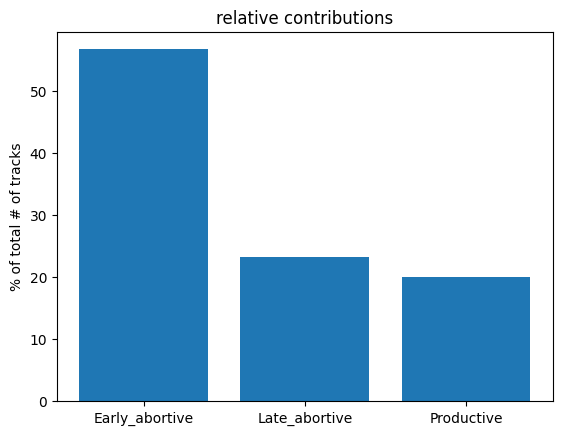

In [135]:
# Plot
contri_early = Table_Classify.at["Early abortive", "Relative contributions"]
contri_late = Table_Classify.at["Late abortive", "Relative contributions"]
contri_productive = Table_Classify.at["Productive", "Relative contributions"]
contribution = [contri_early, contri_late, contri_productive]
x_label = ["Early_abortive", "Late_abortive", "Productive"]
x=np.arange(len(x_label))
plt.bar(x, contribution, tick_label=x_label)
plt.title("relative contributions")
plt.ylabel("% of total # of tracks")
plt.show()

5. Lifetime Median, Q1 and Q3

5.1 Build up dataframe according to the classification

In [136]:
#Simplify the table
Table_boxplot = Normalized_df.copy()
Table_boxplot = Table_boxplot.drop(columns=["Population from F(t)", "Population from S(t)"])

#Get MaxInd of each population
Table_count = Table_boxplot.groupby("Classification").count()
Table_count.rename(columns = {"Histogram merged population":"Track count"}, inplace = True)
Table_count = Table_count.drop(columns=['Lifetime'])
ct_early = Table_count.at["Early abortive", "Track count"]
ct_late = Table_count.at["Late abortive", "Track count"]

#Split the data into three categories
df_3_cat = Table_boxplot.copy()
df_early_idx = df_3_cat[df_3_cat["Classification"]=="Early abortive"].index
df_late_idx = df_3_cat[df_3_cat["Classification"]=="Late abortive"].index
df_productive_idx = df_3_cat[df_3_cat["Classification"]=="Productive"].index
df_early = df_3_cat.drop(df_late_idx.to_list() + df_productive_idx.to_list())
df_late = df_3_cat.drop(df_early_idx.to_list() + df_productive_idx.to_list())
df_productive = df_3_cat.drop(df_early_idx.to_list() + df_late_idx.to_list())

# Accumulate sum of the Normalized track polulation
df_early['Normalized track population'] = df_early['Normalized track population']*100/contri_early
df_early["AccSum_Normalized track population"] = df_early['Normalized track population'].cumsum()
df_early = df_early.drop(columns =["Normalized track population", "Histogram merged population"])

df_late['Normalized track population'] = df_late['Normalized track population']*100/contri_late
df_late["AccSum_Normalized track population"] = df_late['Normalized track population'].cumsum()
df_late = df_late.drop(columns =["Normalized track population", "Histogram merged population"])

df_productive['Normalized track population'] = df_productive['Normalized track population']*100/contri_productive
df_productive["AccSum_Normalized track population"] = df_productive['Normalized track population'].cumsum()
df_productive = df_productive.drop(columns =["Normalized track population", "Histogram merged population"])
df_productive

,Lifetime,Classification,AccSum_Normalized track population
30,15.050,Productive,0.015110
31,15.498,Productive,0.029571
32,15.652,Productive,0.043823
33,16.254,Productive,0.057330
34,16.856,Productive,0.070188
...,...,...,...
186,312.174,Productive,0.984120
187,343.170,Productive,0.988093
188,380.808,Productive,0.992063
189,394.092,Productive,0.996032


In [137]:
# Q1, Median, Q3 of early abortive
Q_earlyArray=[df_early["Lifetime"].iloc[0]]
df_early_ct = len(df_early.index)
for ind in range(0, df_early_ct):
    if df_early["AccSum_Normalized track population"].iloc[ind] >=0.25:####### Error prone
        Q_earlyArray.append(df_early["Lifetime"].iloc[ind])
        break
for ind in range(0, df_early_ct):
    if df_early["AccSum_Normalized track population"].iloc[ind] >=0.5:
        Q_earlyArray.append(df_early["Lifetime"].iloc[ind])
        break
for ind in range(0, df_early_ct):
    if df_early["AccSum_Normalized track population"].iloc[ind] >=0.75:
        Q_earlyArray.append(df_early["Lifetime"].iloc[ind])
        break
for ind in range(0, df_early_ct):
    if df_early["AccSum_Normalized track population"].iloc[ind] >=0.999999:
        Q_earlyArray.append(df_early["Lifetime"].iloc[ind])
print(Q_earlyArray)

[0.602, 0.602, 1.204, 1.806, 3.01]


In [138]:
# Q1, Median, Q3 of late abortive
Q_lateArray=[df_late["Lifetime"].iloc[0]]
for ind in df_late.index:
    if df_late["AccSum_Normalized track population"].iloc[ind] >=0.25:
        Q_lateArray.append(df_late["Lifetime"].iloc[ind])
        break
for ind in df_late.index:
    if df_late["AccSum_Normalized track population"].iloc[ind] >=0.5:
        Q_lateArray.append(df_late["Lifetime"].iloc[ind])
        break
for ind in df_late.index:
    if df_late["AccSum_Normalized track population"].iloc[ind] >=0.75:
        Q_lateArray.append(df_late["Lifetime"].iloc[ind])
        break
for ind in df_late.index:
    if df_late["AccSum_Normalized track population"].iloc[ind] >=0.99999999:
        Q_lateArray.append(df_late["Lifetime"].iloc[ind])
        break
print(Q_lateArray)

[3.612, 6.622, 6.622, 8.856, 14.448]


In [139]:
# Q1, Median, Q3 of productive
Q_productiveArray=[df_productive["Lifetime"].iloc[0]]
for ind in df_productive.index:
    if df_productive["AccSum_Normalized track population"].iloc[ind] >=0.25:
        Q_productiveArray.append(df_productive["Lifetime"].iloc[ind])
        break
for ind in df_productive.index:
    if df_productive["AccSum_Normalized track population"].iloc[ind] >=0.5:
        Q_productiveArray.append(df_productive["Lifetime"].iloc[ind])
        break
for ind in df_productive.index:
    if df_productive["AccSum_Normalized track population"].iloc[ind] >=0.75:
        Q_productiveArray.append(df_productive["Lifetime"].iloc[ind])
        break
for ind in df_productive.index:
    if df_productive["AccSum_Normalized track population"].iloc[ind] >=0.99999999:
        Q_productiveArray.append(df_productive["Lifetime"].iloc[ind])
        break
print(Q_productiveArray)

[15.05, 30.702, 53.136, 115.128, 489.294]


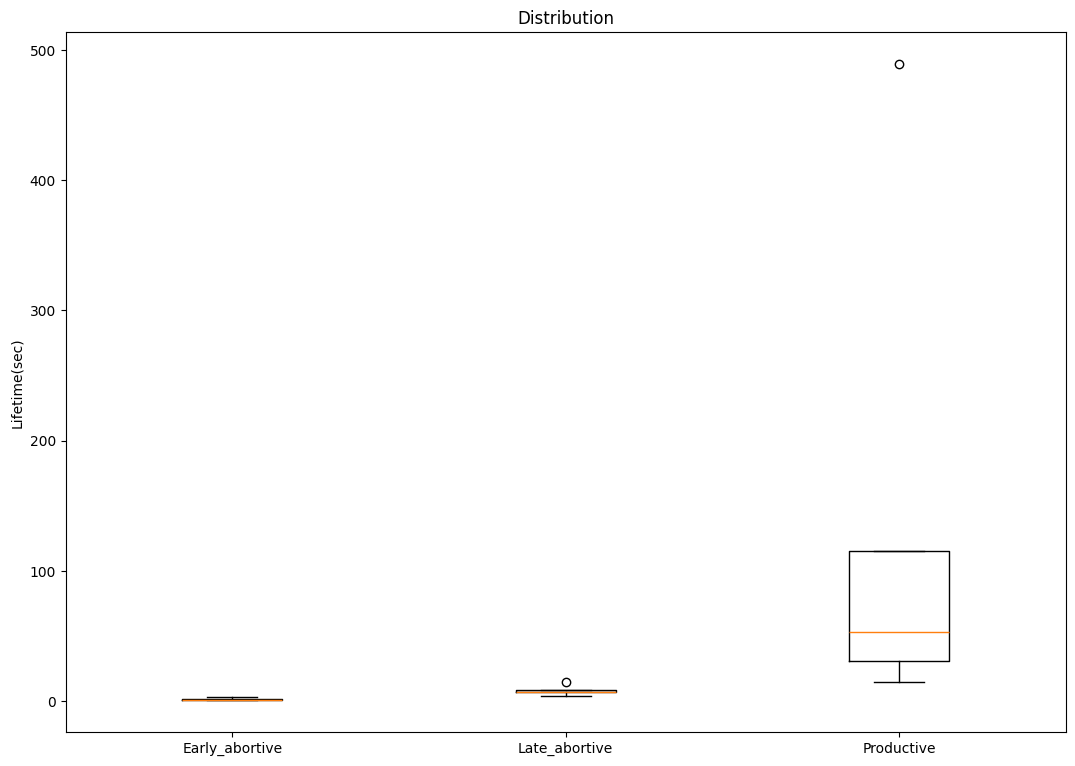

In [140]:
# Plot
data = [Q_earlyArray, Q_lateArray, Q_productiveArray]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0 , 1 ,1])
bp = ax.boxplot(data)
plt.title("Distribution")
plt.xticks([1, 2, 3], ["Early_abortive", "Late_abortive", "Productive"])
plt.ylabel("Lifetime(sec)")
plt.show()

# 6. Calculate mean

In [141]:
Table_boxplot

,Lifetime,Histogram merged population,Normalized track population,Classification
0,0.602,4.653818,0.224109,Early abortive
1,1.204,2.609224,0.125650,Early abortive
2,1.806,1.574557,0.075824,Early abortive
3,2.214,1.172944,0.056484,Early abortive
4,2.408,1.033933,0.049790,Early abortive
...,...,...,...,...
186,312.174,0.016574,0.000798,Productive
187,343.170,0.016553,0.000797,Productive
188,380.808,0.016540,0.000797,Productive
189,394.092,0.016538,0.000796,Productive


In [142]:
# Group
Table_boxplot["Normalized track population * Lifetime"] = Table_boxplot["Normalized track population"] * Table_boxplot["Lifetime"]
Table_boxplot_Classify = Table_boxplot.groupby("Classification").sum()
Table_boxplot_Classify["Lifetime mean"] = Table_boxplot_Classify["Normalized track population * Lifetime"]/Table_boxplot_Classify["Normalized track population"]
Table_boxplot_Classify = Table_boxplot_Classify.drop(columns = ['Lifetime',"Histogram merged population", "Normalized track population", "Normalized track population * Lifetime"])
Table_boxplot_Classify

,Lifetime mean
Classification,
Early abortive,1.365920
Late abortive,6.980101
Productive,83.313514
